In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

We have two different types of gauge: GPS gauges and pressure gauges. In the latter case, the observed variable is pressure. We deduce free surface elevation from pressure using hydrostatic assumptions:

$$p_{\mathrm{hydrostatic}}=\rho gh,$$

where $\rho\approx1030.0\,\mathrm{kg\,m}^{-3}$ is the density of sea water, $g\approx9.81\,\mathrm{m\,s}^{-2}$ is gravitational acceleration and $H$ is the height of the fluid column.

The height of the fluid column may be decomposed as

$$H=b + \eta,$$

where the bathymetry $b$ $[\mathrm m]$ is known and $\eta$ is the free surface displacement we seek.

_[These calculations are performed using_ `preproc.py`, _which outputs the_ `.dat` _files.]_

In [2]:
pressure_gauges = ('P02', 'P06')
gps_gauges = ('801', '802', '803', '804', '806')
gauges = pressure_gauges + gps_gauges

In [3]:
gauge_dict = {gauge: {} for gauge in gauges}
for gauge in gauges:
    gauge_dict[gauge]['times'] = []
    gauge_dict[gauge]['data'] = []

We take running averages for the pressure gauges since they have more frequent measurements.

In [4]:
def read_and_sample(g, sample=1):
    time_prev = 0.0
    num_lines = sum(1 for line in open(g+'.dat', 'r'))
    t = []
    d = []
    with open(g+'.dat', 'r') as f:
        running = 0
        for i in range(num_lines):
            line = f.readline()
            time, dat = line.split()
            time = float(time)
            dat = float(dat)
            running += dat
            if (gauge in pressure_gauges or sample % 5 == 0) and i % sample == 0 and i > 0:
                if time < time_prev:
                    break  # FIXME
                t.append(0.5*(time + time_prev))
                d.append(running/sample)
                running = 0
                time_prev = time
            elif gauge in gps_gauges and sample % 5 != 0:
                t.append(time)
                d.append(dat)
    return t, d

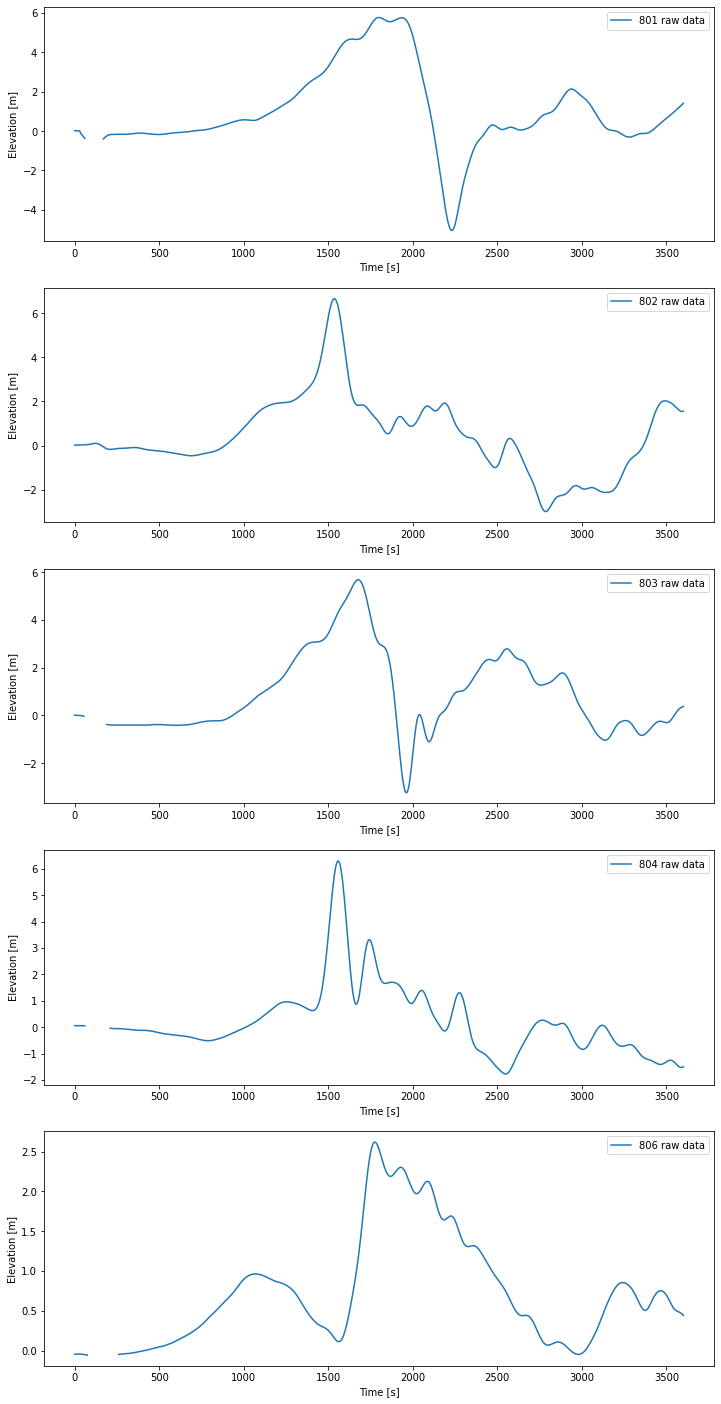

In [5]:
for gauge in gps_gauges:
    gauge_dict[gauge]['times'], gauge_dict[gauge]['data'] = read_and_sample(gauge)

fig, axes = plt.subplots(nrows=len(gps_gauges), figsize=(12, 5*len(gps_gauges)))
for i, gauge in enumerate(gps_gauges):
    ax = axes[i]
    ax.plot(gauge_dict[gauge]['times'], gauge_dict[gauge]['data'], label=gauge.title() + ' raw data')
    ax.set_xlabel("Time [s]");
    ax.set_ylabel("Elevation [m]");
    ax.legend();

For the pressure gauges, we also have free surface elevation data extracted from the figure in [Saito et al. 2011] using `PlotDigitizer`.

In [6]:
plot_digitizer = {}
plot_digitizer["P02"] = [
    0.00, 0.07, 0.12, 0.46, 0.85, 1.20, 1.55, 1.90, 2.25, 2.50, 2.80, 3.10, 3.90, 4.80,
    4.46, 2.25, -0.45, -0.17, -1.60, -0.82, -0.44, -0.26, -0.08, 0.13, 0.42, 0.71
]
plot_digitizer["P06"] = [
    0.00, 0.10, 0.30, 0.65, 1.05, 1.35, 1.65, 1.95, 2.25, 2.55, 2.90, 3.50, 4.50, 4.85,
    3.90, 1.55, -0.35, -1.05, -0.65, -0.30, -0.15, 0.05, 0.18, 0.35, 0.53, 0.74
]

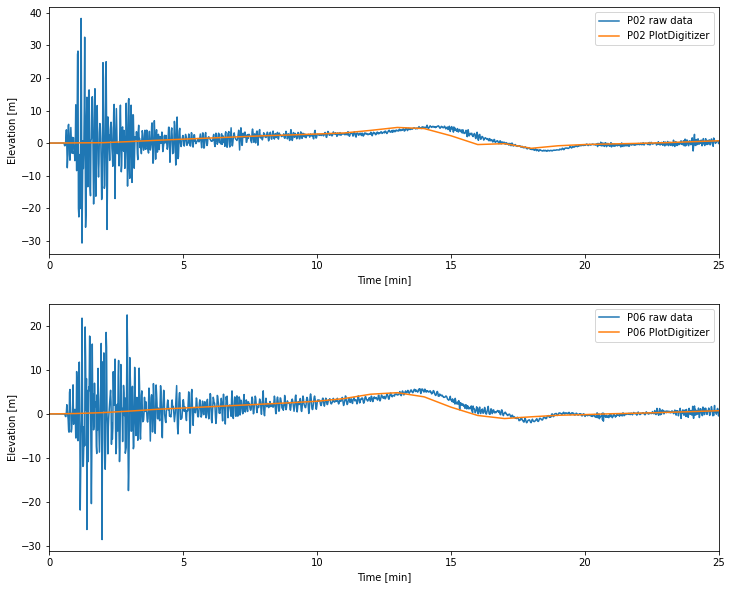

In [8]:
for gauge in pressure_gauges:
    gauge_dict[gauge]['times'], gauge_dict[gauge]['data'] = read_and_sample(gauge)

fig, axes = plt.subplots(nrows=len(pressure_gauges), figsize=(12, 5*len(pressure_gauges)))
for i, gauge in enumerate(pressure_gauges):
    ax = axes[i]
    N = len(plot_digitizer[gauge])
    times = np.array(gauge_dict[gauge]['times'])/60.0
    elev = np.array(gauge_dict[gauge]['data'])
    elev -= elev[1]
    elev[0] = 0
    ax.plot(times, elev, label=gauge.title() + ' raw data')
    ax.plot(range(N), plot_digitizer[gauge], label=gauge.title()+' PlotDigitizer')
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    ax.set_xlim([0, N-1])
    ax.legend();
plt.savefig("pressure_gauges_raw.png")

We see that there is a lot of noise in this data, especially near the start of the observation period.
It also looks like the raw data and `PlotDigitizer` are out of date.

Let's try sampling over windows and taking the average for a few different sample sizes.

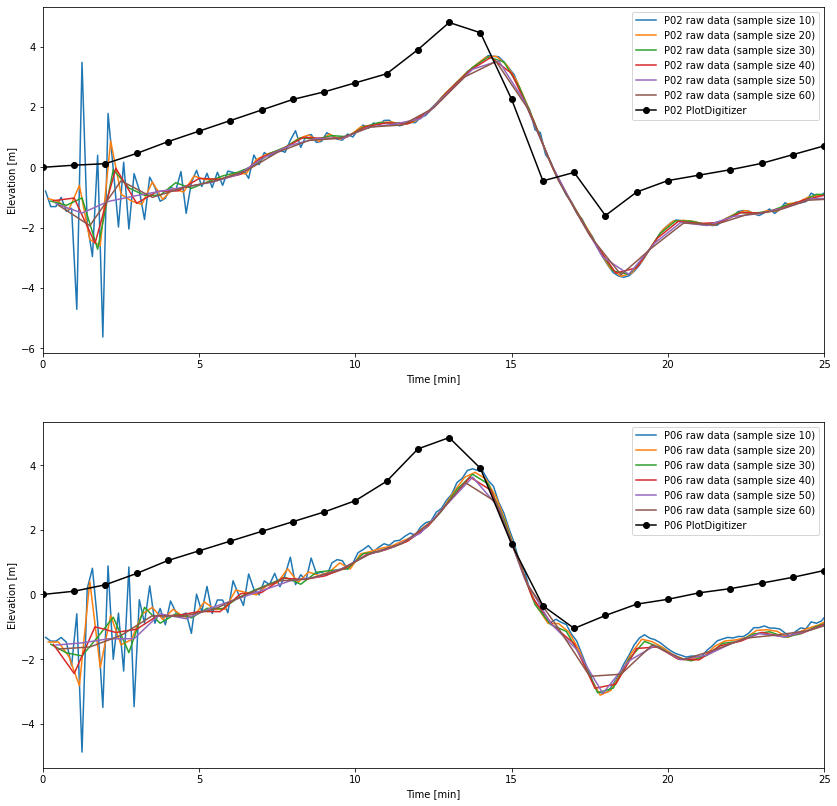

In [8]:
fig, axes = plt.subplots(nrows=len(pressure_gauges), figsize=(14, 7*len(pressure_gauges)))
for i, gauge in enumerate(pressure_gauges):
    ax = axes[i]
    N = len(plot_digitizer[gauge])
    for sample in range(10, 70, 10):
        gauge_dict[gauge]['times'], gauge_dict[gauge]['data'] = read_and_sample(gauge, sample=sample)
    
        times = np.array([time/60.0 for time in gauge_dict[gauge]['times']])
        elev = np.array(gauge_dict[gauge]['data'])
        elev = np.array([eta for eta, time in zip(elev, times)])
        elev -= elev[-1]  # tie them all at the end (we can't tie them at the start because of the noise)
        ax.plot(times, elev, label='{:s} raw data (sample size {:d})'.format(gauge.title(), sample))
    ax.plot(range(N), plot_digitizer[gauge], marker='o', color='k', label=gauge.title()+' PlotDigitizer')
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    ax.set_xlim([0, N-1])
    ax.legend();

It looks like the observations and the `PlotDigitizer` data are about one minute out of sync:

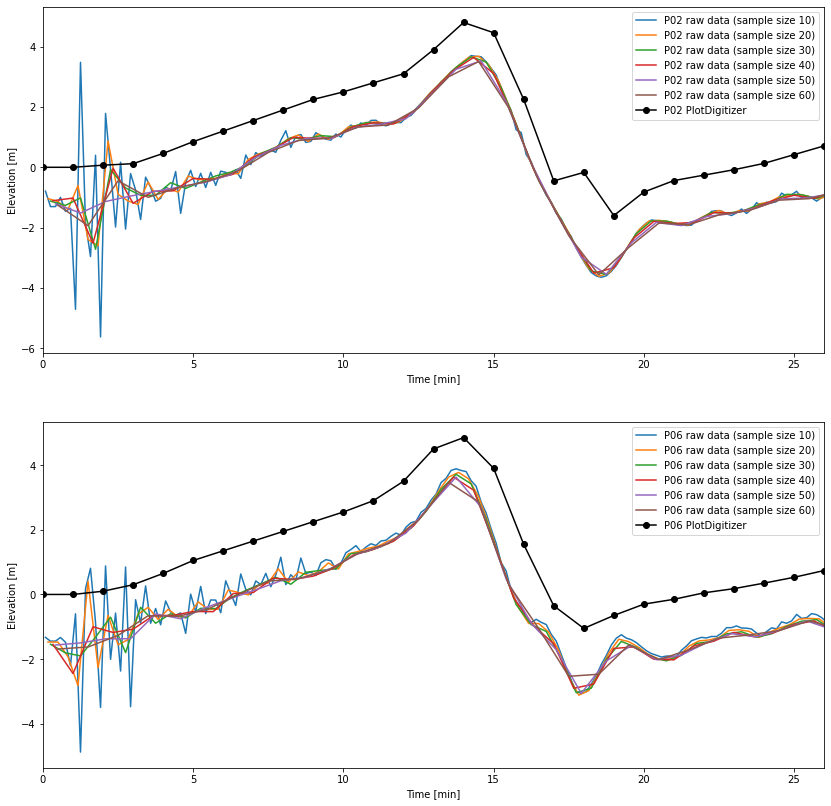

In [9]:
fig, axes = plt.subplots(nrows=len(pressure_gauges), figsize=(14, 7*len(pressure_gauges)))
for i, gauge in enumerate(pressure_gauges):
    ax = axes[i]
    plot_digitizer_ = [0.0, ]  # Push back a minute
    plot_digitizer_.extend(plot_digitizer[gauge])
    N = len(plot_digitizer_)
    for sample in range(10, 70, 10):
        gauge_dict[gauge]['times'], gauge_dict[gauge]['data'] = read_and_sample(gauge, sample=sample)
    
        times = np.array([time/60.0 for time in gauge_dict[gauge]['times']])
        elev = np.array(gauge_dict[gauge]['data'])
        elev = np.array([eta for eta, time in zip(elev, times)])
        elev -= elev[-1]  # tie them all at the end
        ax.plot(times, elev, label='{:s} raw data (sample size {:d})'.format(gauge.title(), sample))
    ax.plot(range(N), plot_digitizer_, marker='o', color='k', label=gauge.title()+' PlotDigitizer')
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    ax.set_xlim([0, N-1])
    ax.legend();

It looks like we can disregard sample sizes 10 and 20 as they contain too much noise.

Let's take the data sampled at every second, find how much we need to add to get it to start at zero and then add this to each sampled version:

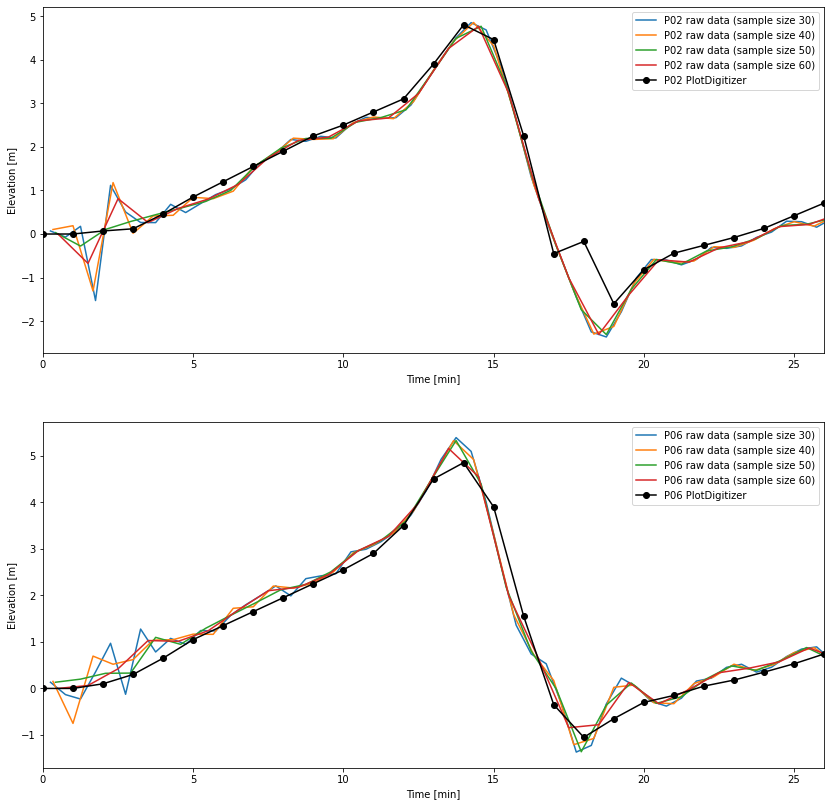

In [9]:
fig, axes = plt.subplots(nrows=len(pressure_gauges), figsize=(14, 7*len(pressure_gauges)))
for i, gauge in enumerate(pressure_gauges):
    gauge_dict[gauge]['times'], gauge_dict[gauge]['data'] = read_and_sample(gauge, sample=60)
    init = gauge_dict[gauge]['data'][0]

    ax = axes[i]
    plot_digitizer_ = [0.0, ]  # Push back a minute
    plot_digitizer_.extend(plot_digitizer[gauge])
    N = len(plot_digitizer_)
    for sample in range(30, 70, 10):
        gauge_dict[gauge]['times'], gauge_dict[gauge]['data'] = read_and_sample(gauge, sample=sample)
    
        times = np.array([time/60.0 for time in gauge_dict[gauge]['times']])
        elev = np.array(gauge_dict[gauge]['data'])
        elev = np.array([eta for eta, time in zip(elev, times)])
        
        elev -= init
        
        ax.plot(times, elev, label='{:s} raw data (sample size {:d})'.format(gauge.title(), sample))
    ax.plot(range(N), plot_digitizer_, marker='o', color='k', label=gauge.title()+' PlotDigitizer')
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    ax.set_xlim([0, N-1])
    ax.legend();
plt.savefig("sampled_pressure_gauge_data.png")